All needed librarys

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.nddata import Cutout2D
from astropy import units
from astropy.io import fits
from astropy.modeling.models import Gaussian2D
import glob
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from clustar.core import ClustarData

Define Size of image in pixels and object in image
The object is a standard object from astropy, the idea is to use one of our own gaussian.

In [10]:
y, x = np.mgrid[0:500, 0:500]
data = Gaussian2D(1, 250, 250, 10, 5, theta=3)(x, y)


Here we plot the actual image

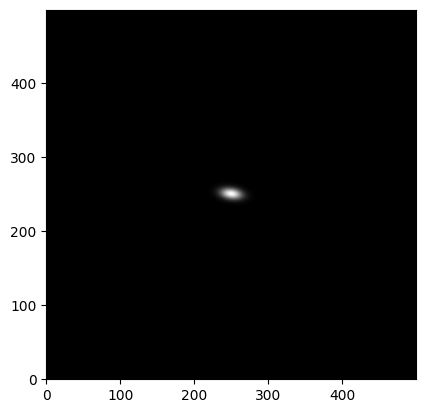

In [11]:
plt.imshow(data, origin='lower', cmap='gray')
plt.show()

Lets say we want to crop the image to a standard size 

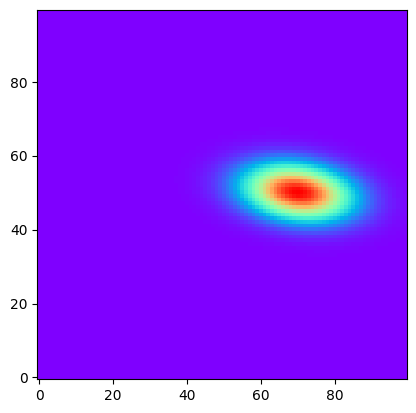

In [12]:
crop_center = (230, 250)
crop_size = units.Quantity((100, 100), units.pixel)
crop = Cutout2D(data, crop_center, crop_size)

plt.imshow(crop.data, origin='lower', cmap='rainbow')
plt.show()

Load a FITS file instead of simulating

In [13]:
#Get all the fits files adresses un a dictionary
filenames = glob.glob('data/*.fits')
data_set = {}

Find object of interest in FITS-file and return pos 

In [38]:
def find_object_pos(file):

    cd = ClustarData(path=file, group_factor=.4)
    if len(cd.groups) > 0:
        disk = cd.groups[0]
        bounds = disk.image.bounds
        x = (bounds[2] + bounds[3])/2 
        y = (bounds[0] + bounds[1])/2
        return (x, y)
    else:
        print("No object found in {}".format(file))
        return None


Go through all the FITS adresses and print the graphs

No object found in data\hh212_2015_band7_0.fits


TypeError: 'NoneType' object is not subscriptable

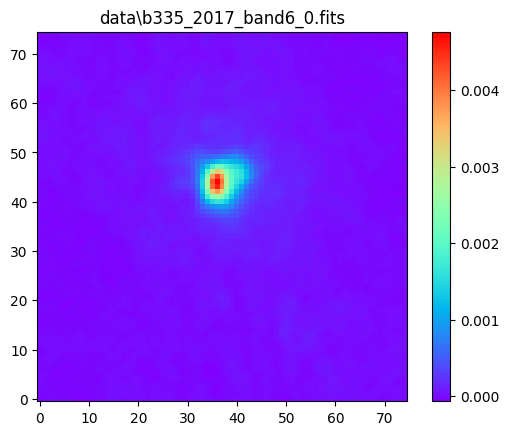

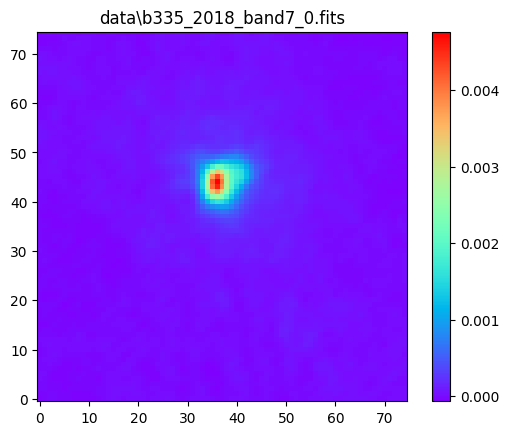

In [39]:
crops = []
for file in filenames:
    img_header = fits.open(file)
    img_data = fits.getdata(file)
    object_pos = find_object_pos(file)

    if object_pos != None:

        #Data shape is (1, 1, x, y) we want it to be (x, y)
        img_data.shape = (img_data.shape[2], img_data.shape[3])

        # Set the size of the crop in pixels
        im_size = 75
        crop_size = units.Quantity((im_size, im_size), units.pixel)

        img_crop = Cutout2D(img_data, object_pos, crop_size)

        crops.append(img_crop)

        plt.figure()
        plt.imshow(img_crop.data, origin='lower', cmap='rainbow')
        plt.colorbar()
        plt.title(file)


Augment Data

In [ ]:
print(type(crops[0]))

NameError: name 'crops' is not defined